1. Loading the Dataset

2. Visualising the Data

3. Data Augmentation

4. Image Re-Sizing & Processing

5. Train - Test Split

6. Building EfficientNet model

7. Prediction and Evaluation


In [1]:
# !pip install imgaug

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB4
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the Dataset

In [3]:
# Set data paths
data_path = "bttai-ajl-2025/"
train_dir = data_path + 'train/'
test_dir = data_path + 'test/'

In [4]:
train_dir

'bttai-ajl-2025/train/'

In [5]:
# Load Data
df_train = pd.read_csv(data_path + 'train.csv', encoding='utf-8')
df_test = pd.read_csv(data_path + 'test.csv')

In [6]:
df_train.shape

(2860, 8)

In [7]:
df_test.shape

(1227, 5)

# Visualize the Images from our dataset

In [8]:
CATEGORIES = list(df_train['label'].unique())
CATEGORIES

['prurigo-nodularis',
 'basal-cell-carcinoma-morpheiform',
 'keloid',
 'basal-cell-carcinoma',
 'seborrheic-keratosis',
 'eczema',
 'folliculitis',
 'squamous-cell-carcinoma',
 'actinic-keratosis',
 'mycosis-fungoides',
 'acne-vulgaris',
 'dyshidrotic-eczema',
 'melanoma',
 'epidermal-nevus',
 'malignant-melanoma',
 'pyogenic-granuloma',
 'dermatofibroma',
 'kaposi-sarcoma',
 'acne',
 'dermatomyositis',
 'superficial-spreading-melanoma-ssm']

C:\Users\Rebecca\AppData\Local\Temp\ipykernel_11836\3772603041.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,3, figsize=(10,4))


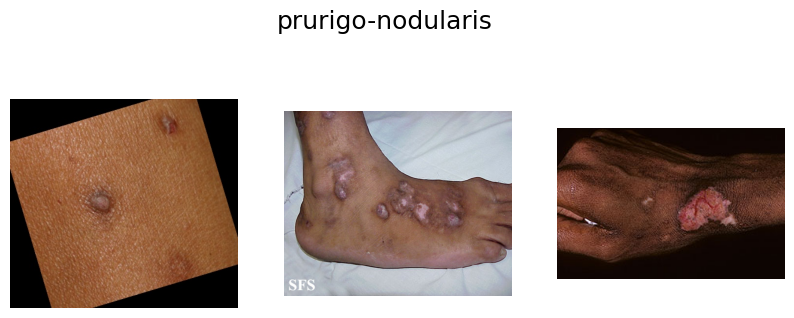

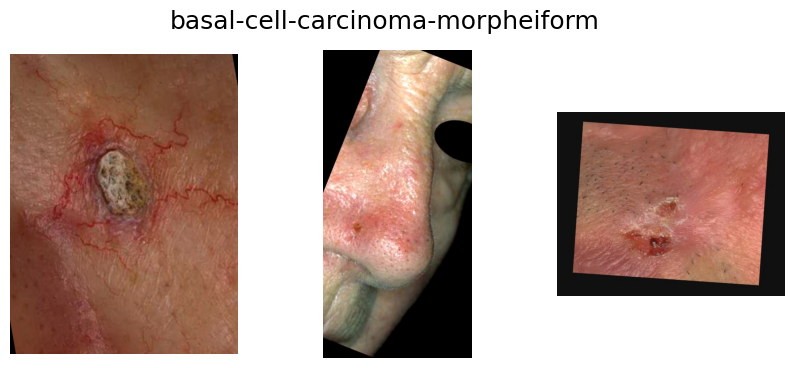

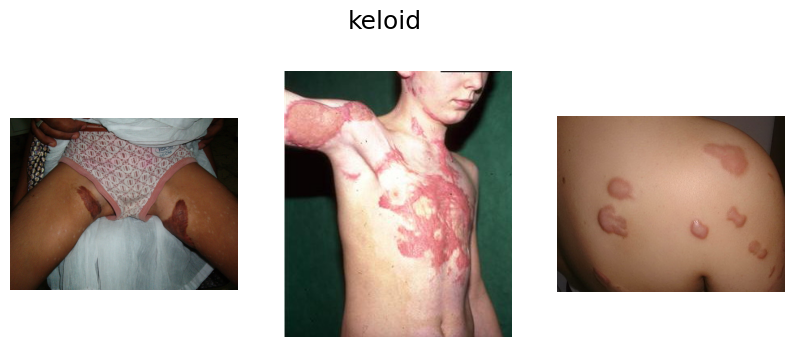

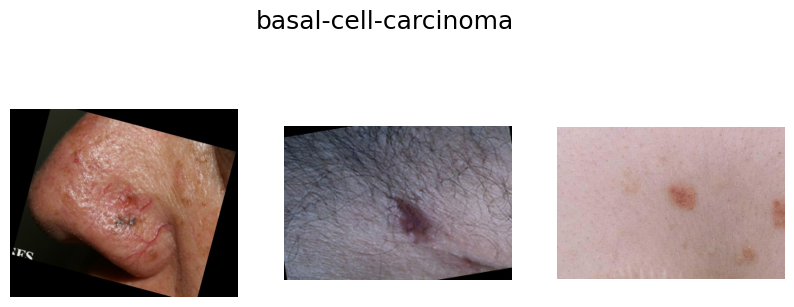

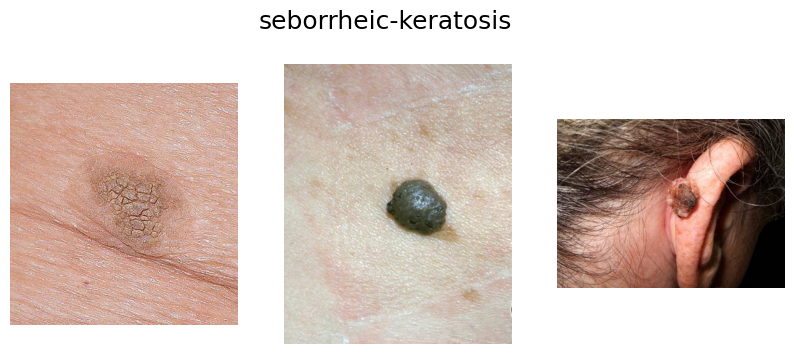

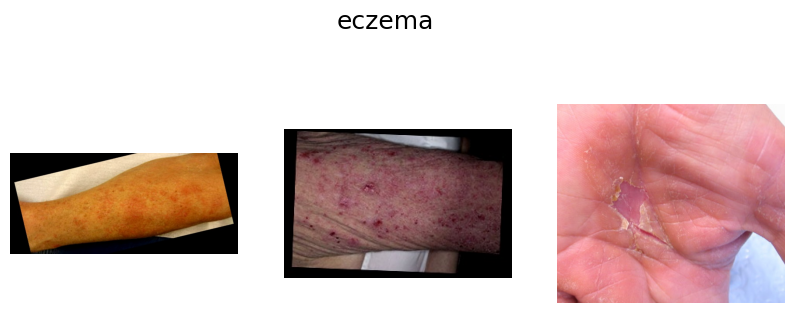

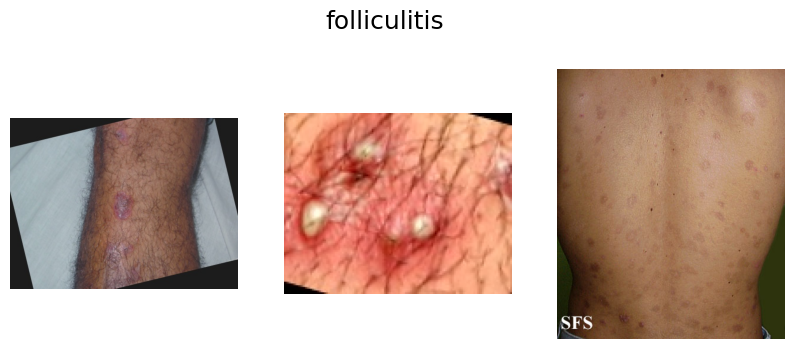

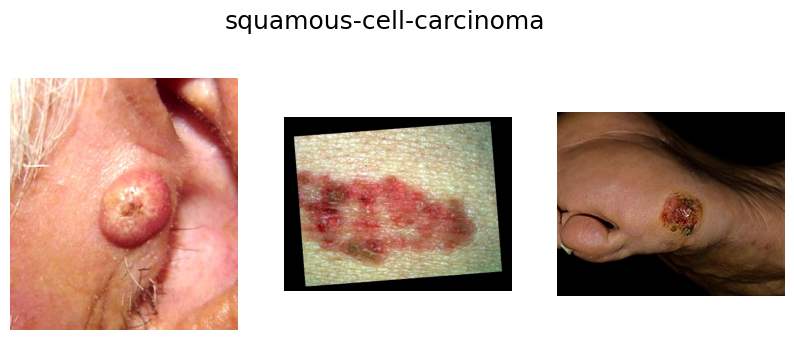

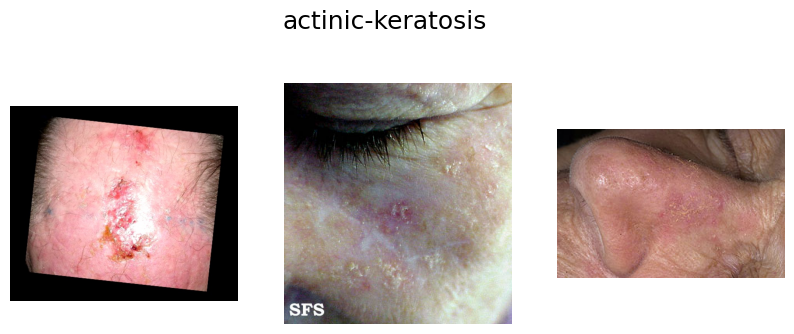

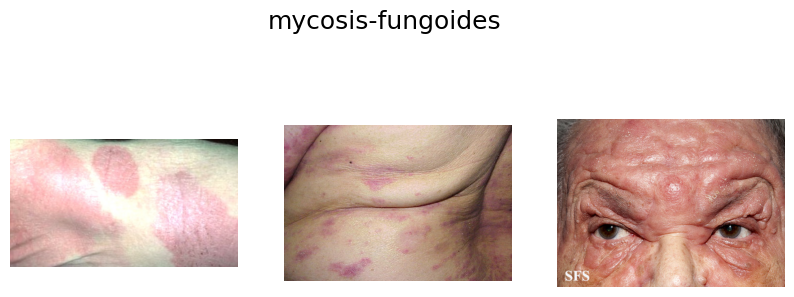

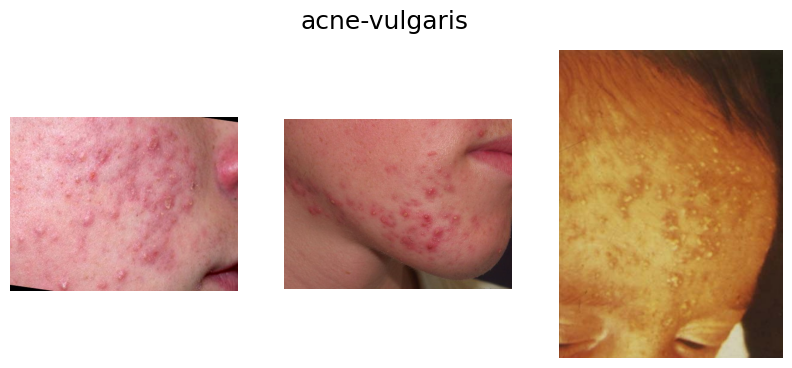

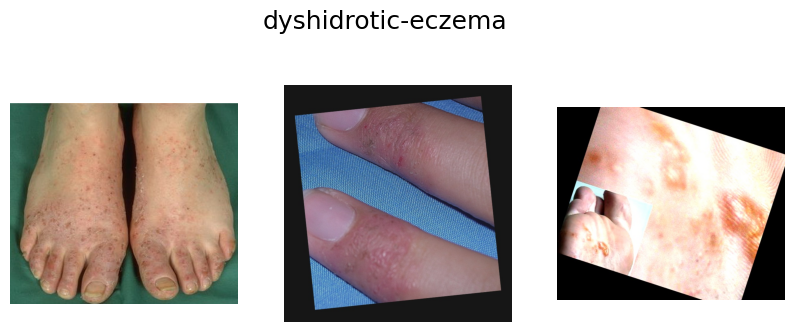

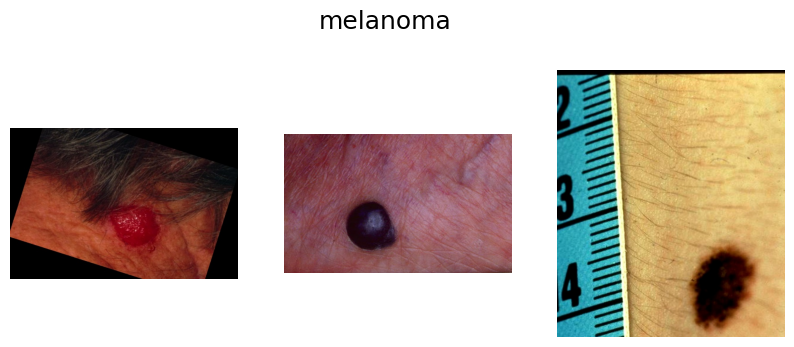

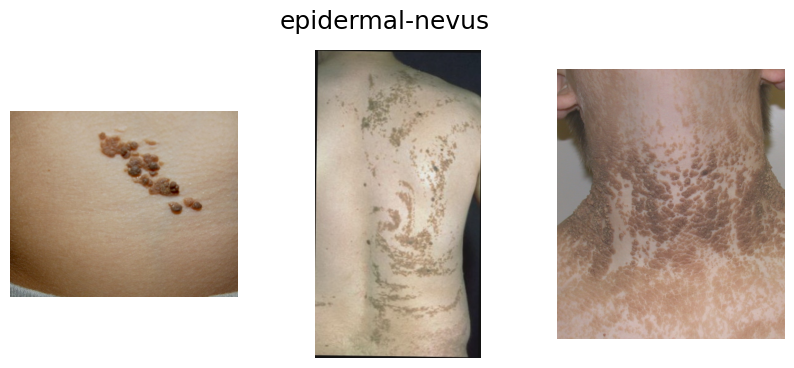

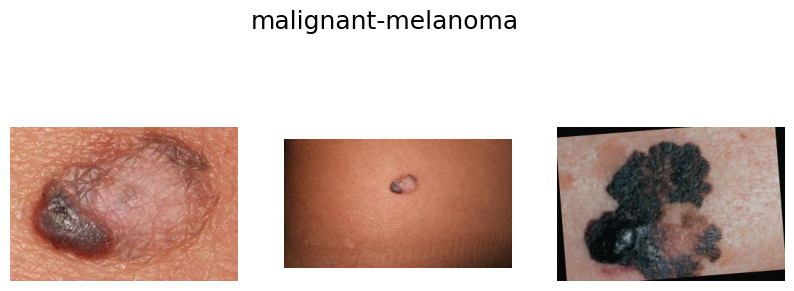

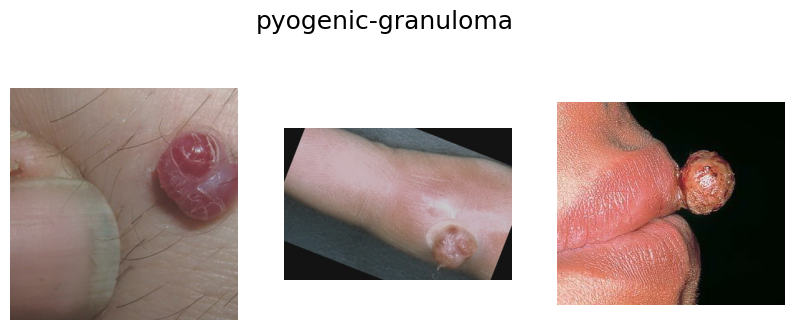

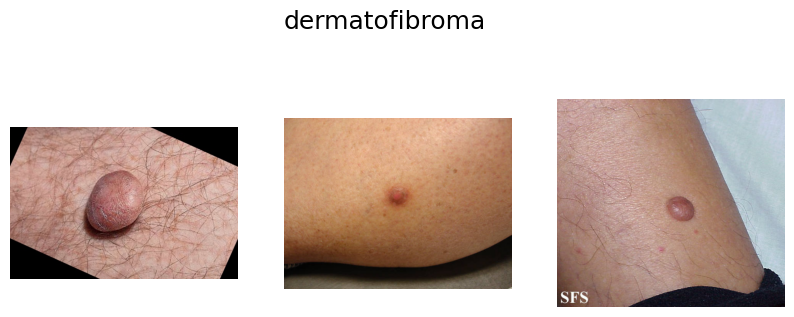

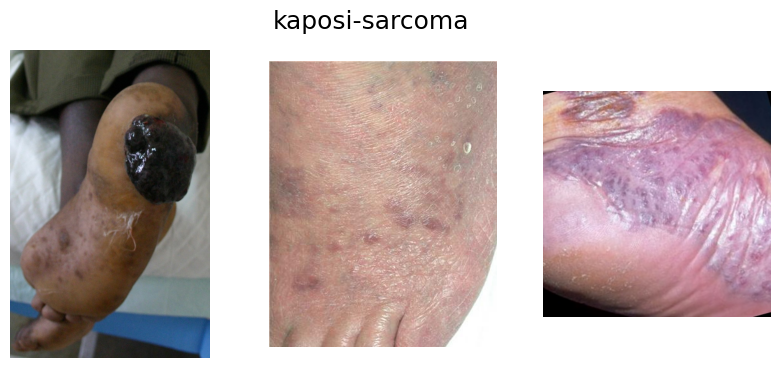

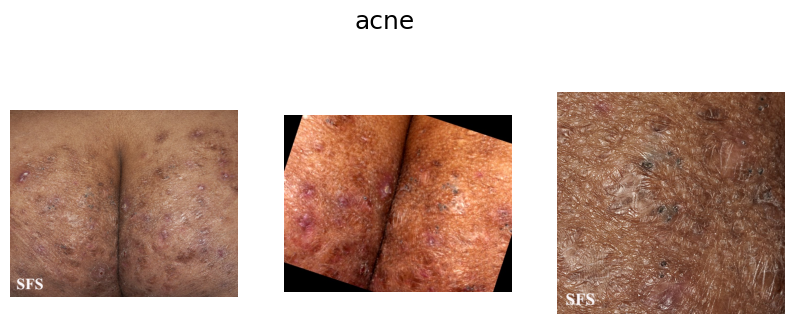

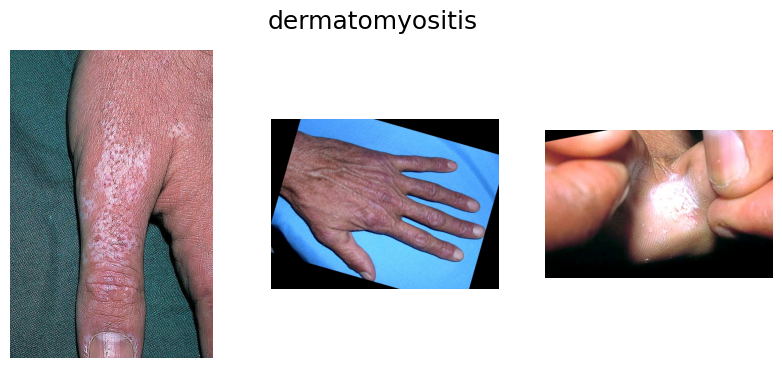

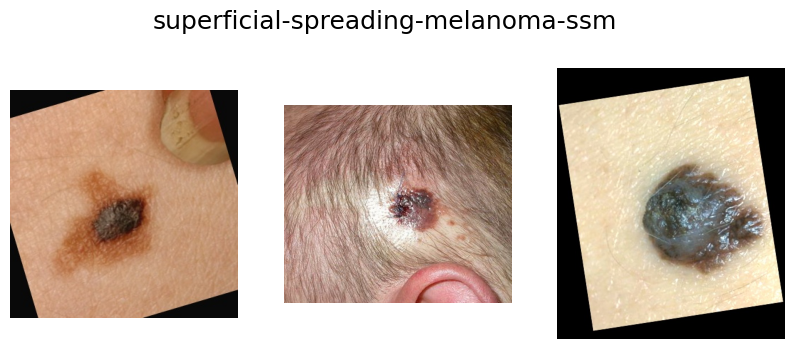

In [9]:
# Visualizing the images
for category in CATEGORIES:
    path = os.path.join(train_dir, category)
    images = os.listdir(path)
    
    fig, ax = plt.subplots(1,3, figsize=(10,4))
    fig.suptitle(f'{category}', fontsize=18)

    for i in range(3):
        img_name = images[np.random.randint(0, len(images))]
        img_path = os.path.join(path, img_name)
        img_array = cv2.imread(img_path)

        # Convert the cv2 BGR colors to RGB colors
        img_rgb = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        
        ax[i].imshow(img_rgb)
        ax[i].axis('off')
        

# Count the number of images in each directory
This helps us determine whether the augmentation was successful. If the augmentation was successful, the number of images will increase. However, if the number of images remains the same, it indicates that the augmentation failed.

In [10]:
# Lets count the images in each directory
def count_images(dir):
    for category in CATEGORIES:
        path = os.path.join(dir, category)
        images = os.listdir(path)
        num_images = len(images)
        print(f'{category} : {num_images} images')
        
count_images(train_dir)

prurigo-nodularis : 238 images
basal-cell-carcinoma-morpheiform : 86 images
keloid : 218 images
basal-cell-carcinoma : 656 images
seborrheic-keratosis : 96 images
eczema : 286 images
folliculitis : 478 images
squamous-cell-carcinoma : 814 images
actinic-keratosis : 244 images
mycosis-fungoides : 254 images
acne-vulgaris : 468 images
dyshidrotic-eczema : 116 images
melanoma : 362 images
epidermal-nevus : 128 images
malignant-melanoma : 156 images
pyogenic-granuloma : 158 images
dermatofibroma : 110 images
kaposi-sarcoma : 218 images
acne : 256 images
dermatomyositis : 212 images
superficial-spreading-melanoma-ssm : 166 images


# Data Augmentation
### Comment out when already done, otherwise it keeps building

In [11]:
# # Define augmentation pipeline
# augmentation_pipeline = iaa.Sequential([
#     iaa.Fliplr(0.5),  # Horizontally flip 50% of images
#     iaa.Crop(percent=(0, 0.1)),  # Random crop up to 10%
#     iaa.Affine(scale=(0.8, 1.2), rotate=(-25, 25)),  # Scale & Rotate
#     iaa.Multiply((0.8, 1.2)),  # Adjust brightness
#     iaa.LinearContrast((0.75, 1.5))  # Adjust contrast
# ])

In [12]:
# def augment_images(directory: str, augmenter: iaa.Sequential) -> None:
#     """Apply image augmentation to all images in subdirectories."""
    
#     directory_path = Path(directory)
    
#     if not directory_path.exists():
#         print(f"Error: Directory '{directory}' does not exist.")
#         return
    
#     for category in CATEGORIES:
#         category_path = directory_path / category
        
#         if not category_path.exists():
#             print(f"Warning: Category directory '{category}' not found. Skipping.")
#             continue
            
#         print(f'Starting Augmentation on: {category}')
#         for file in category_path.iterdir():
#             if file.suffix.lower() not in [".jpg", ".jpeg", ".png"]:
#                 continue  # Skip non-image files
            
#             img = cv2.imread(str(file))  # OpenCV loads in BGR format
            
#             if img is None:
#                 print(f"Warning: Failed to load {file}. Skipping.")
#                 continue

#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for imgaug
            
#             augmented_img = augmenter.augment_image(img)  # Apply augmentation
            
#             # Convert back to BGR before saving
#             augmented_img_bgr = cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR)
            
#             new_filename = f"{file.stem}_augmented{file.suffix}"
#             augmented_path = category_path / new_filename
#             cv2.imwrite(str(augmented_path), augmented_img_bgr)

# # Run the augmentation
# augment_images(train_dir, augmentation_pipeline)

# Verify if augmentation worked
### Each category should have more images

In [13]:
# The numbers should be dramatically different
count_images(train_dir)

prurigo-nodularis : 238 images
basal-cell-carcinoma-morpheiform : 86 images
keloid : 218 images
basal-cell-carcinoma : 656 images
seborrheic-keratosis : 96 images
eczema : 286 images
folliculitis : 478 images
squamous-cell-carcinoma : 814 images
actinic-keratosis : 244 images
mycosis-fungoides : 254 images
acne-vulgaris : 468 images
dyshidrotic-eczema : 116 images
melanoma : 362 images
epidermal-nevus : 128 images
malignant-melanoma : 156 images
pyogenic-granuloma : 158 images
dermatofibroma : 110 images
kaposi-sarcoma : 218 images
acne : 256 images
dermatomyositis : 212 images
superficial-spreading-melanoma-ssm : 166 images


# Change Image Size to fit the model
### We need the images to be 224 x 224 or lower

In [14]:
# The images are currently too big (411 x 404)
img_array.shape

(474, 399, 3)

### Resize the images

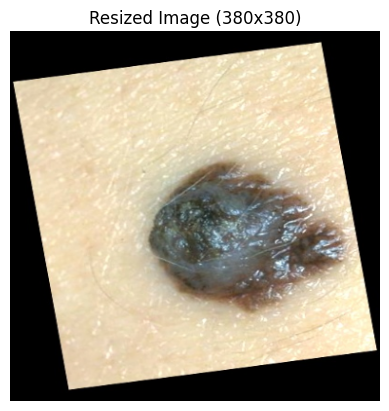

In [15]:
IMG_SIZE = 380

# Assume img_array is already loaded with cv2.imread or similar
sized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))            # Resize to 380x380
sized_img = cv2.cvtColor(sized_img, cv2.COLOR_BGR2RGB)             # Convert from BGR (OpenCV) to RGB (matplotlib)

plt.imshow(sized_img)
plt.axis('off')  # Optional: hide axis
plt.title("Resized Image (380x380)")
plt.show()

# Create the Training Data

In [16]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(train_dir, category)
        label = CATEGORIES.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

                # EfficientNet-specific preprocessing (scales to [-1, 1])
                preprocessed_img = preprocess_input(resized_img)

                training_data.append([preprocessed_img, label])
            except Exception as e:
                pass
            
create_training_data()

In [17]:
len(training_data)

5720

### Get our Features and Label

In [18]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

In [19]:
# Check data type
type(X), type(y)

(list, list)

### Convert the lists into Arrays

In [20]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y)

# Train, Test, Split
#### I split the dataset 30, 70 because I've found it gives better results.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [22]:
print(f'X_train length : {X_train.shape[0]}, X_train Image Size : {X_train.shape[1:3]}, Channel Dimension : {X_train.shape[3]}')
print(f'X_test length : {X_test.shape[0]}, X_test Image Size : {X_test.shape[1:3]}, Channel Dimension : {X_test.shape[3]}')

X_train length : 4004, X_train Image Size : (380, 380), Channel Dimension : 3
X_test length : 1716, X_test Image Size : (380, 380), Channel Dimension : 3


# Build the EfficientNetB4 Model

In [23]:
efficient_net = EfficientNetB4(
    weights = 'imagenet',
    include_top = False,
    input_shape = (IMG_SIZE, IMG_SIZE, 3)
)

### 🔥 Unfreeze last 20 layers to fine-tune

In [24]:
# Unfreeze only the last 20 layers of EfficientNetB4
for layer in efficient_net.layers[:-20]:
    layer.trainable = False

for layer in efficient_net.layers[-20:]:
    layer.trainable = True

### Constructing layers

In [25]:
model = keras.Sequential([
    efficient_net,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(21, activation='softmax') # Reflects our 21 categories
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Compute class weights

In [26]:
# Get unique class labels
class_labels = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print weights for reference
print(class_weight_dict)

{0: 1.2461873638344227, 1: 3.466666666666667, 2: 1.279642058165548, 3: 0.42089771891096395, 4: 2.845771144278607, 5: 0.9678510998307953, 6: 0.5542635658914729, 7: 0.33866193013617524, 8: 1.1021194605009634, 9: 1.0592592592592593, 10: 0.5691542288557214, 11: 2.3833333333333333, 12: 0.714107365792759, 13: 2.353909465020576, 14: 1.7819314641744548, 15: 1.672514619883041, 16: 2.803921568627451, 17: 1.2380952380952381, 18: 0.9777777777777777, 19: 1.2626931567328918, 20: 1.615819209039548}


In [27]:
# Add early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

# Train the model with class weights

In [28]:
# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32, 
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,  # ⚡ Apply class weights
    callbacks=[early_stopping]  # 🚀 Early stopping for efficiency
)

# Save model
model.save("AJL_UCLA_team11_EfficientNet_v11.keras")
print("keras file saved successfully!")

Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 549s 4s/step - accuracy: 0.0641 - loss: 3.0184 - val_accuracy: 0.1672 - val_loss: 2.9233
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 514s 4s/step - accuracy: 0.1981 - loss: 2.8529 - val_accuracy: 0.2448 - val_loss: 2.7992
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 510s 4s/step - accuracy: 0.2656 - loss: 2.7011 - val_accuracy: 0.2821 - val_loss: 2.6599
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 473s 4s/step - accuracy: 0.3159 - loss: 2.5065 - val_accuracy: 0.3094 - val_loss: 2.5200
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 485s 4s/step - accuracy: 0.3534 - loss: 2.3850 - val_accuracy: 0.3403 - val_loss: 2.3832
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.3789 - loss: 2.2274 - val_accuracy: 0.3700 - val_loss: 2.2658
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.4122 - loss: 2.0451 - val_accuracy: 0.3928 - val_loss: 2.1674
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 459s 4s/step - accuracy: 0.4440 - loss: 1.9487 - val_accu

# Evaluate the EfficientNetB4 model

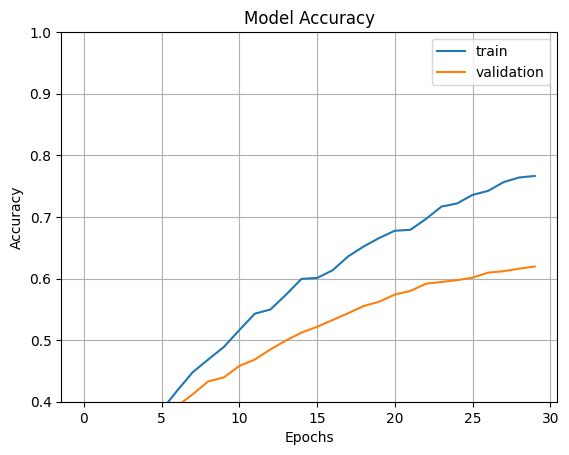

In [29]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6331 - loss: 1.2574
Model Accuracy : 61.946386098861694


# Prediction

#### Predict on a seperate X_test so that we keep our 1227 rows for submission

In [31]:
# Prepare X_test2 to store images for all 1227 rows
X_test2 = []

# Iterate over the rows in df_test
for index, row in df_test.iterrows():
    md5hash = row['md5hash']
    # Construct the image file path using md5hash
    img_path = os.path.join(test_dir, f"{md5hash}.jpg")  # or the correct file extension
    
    # Load and preprocess the image
    try:
        img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        X_test2.append(img_array)
    except FileNotFoundError:
        print(f"Image not found for md5hash: {md5hash}")
        continue

# Convert the list of images to a numpy array
X_test2 = np.array(X_test2)

# Check the shape of X_test2
print(X_test2.shape)  # Should be (1227, IMG_SIZE, IMG_SIZE, 3)

(1227, 380, 380, 3)


#### Make our Prediction

In [32]:
prediction = model.predict(X_test2)
predicted_labels = np.argmax(prediction, axis=-1)

39/39 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step


# Create a DataFrame for Submission

In [33]:
# These should be the same size
print(f"Length of md5hash column: {len(df_test['md5hash'])}")
print(f"Length of predicted_labels: {len(predicted_labels)}")

Length of md5hash column: 1227
Length of predicted_labels: 1227


In [34]:
# Make sure both columns are of the same length before submission
min_length = min(len(df_test["md5hash"]), len(predicted_labels))

In [35]:
min_length

1227

In [36]:
# Convert back to our original name labels (They are index numbers before)
orig_labels = [CATEGORIES[i] for i in predicted_labels]

In [37]:
submission_df = pd.DataFrame({
    "md5hash": df_test["md5hash"].iloc[:min_length],  # Trim if needed
    "label": orig_labels[:min_length]  # Trim if needed
})

submission_df.to_csv("submission_EffNetB4_v11.csv", index=False)
print("CSV file saved successfully!")

CSV file saved successfully!


# Generate the classification report

In [38]:
prediction = model.predict(X_test)  # X_test should have 1144 samples
predicted_labels = np.argmax(prediction, axis=-1)

# Generate the classification report
print(classification_report(y_test, predicted_labels))

54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        85
           1       0.53      0.77      0.63        31
           2       0.75      0.71      0.73        69
           3       0.60      0.50      0.55       203
           4       0.82      0.62      0.71        29
           5       0.53      0.49      0.51        89
           6       0.63      0.67      0.65       134
           7       0.71      0.52      0.60       251
           8       0.37      0.56      0.45        71
           9       0.59      0.74      0.65        74
          10       0.77      0.71      0.74       133
          11       0.72      0.78      0.75        36
          12       0.70      0.55      0.62        95
          13       0.87      0.72      0.79        47
          14       0.48      0.51      0.50        49
          15       0.74      0.80      0.77        44
          16       0.48      0.71      0.

# Check the Class distribution

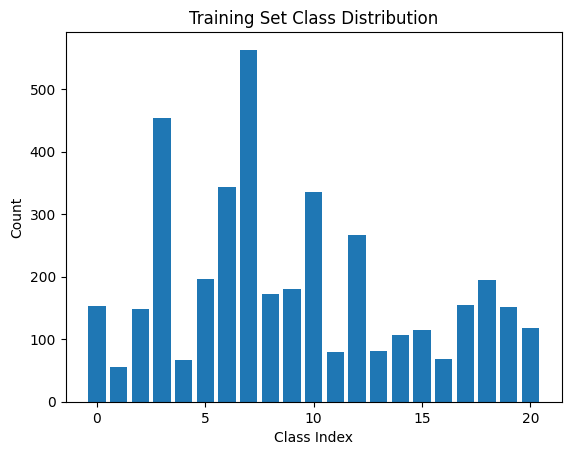

In [39]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.title("Training Set Class Distribution")
plt.show()

### Compute the confusion matrix (with normalization)

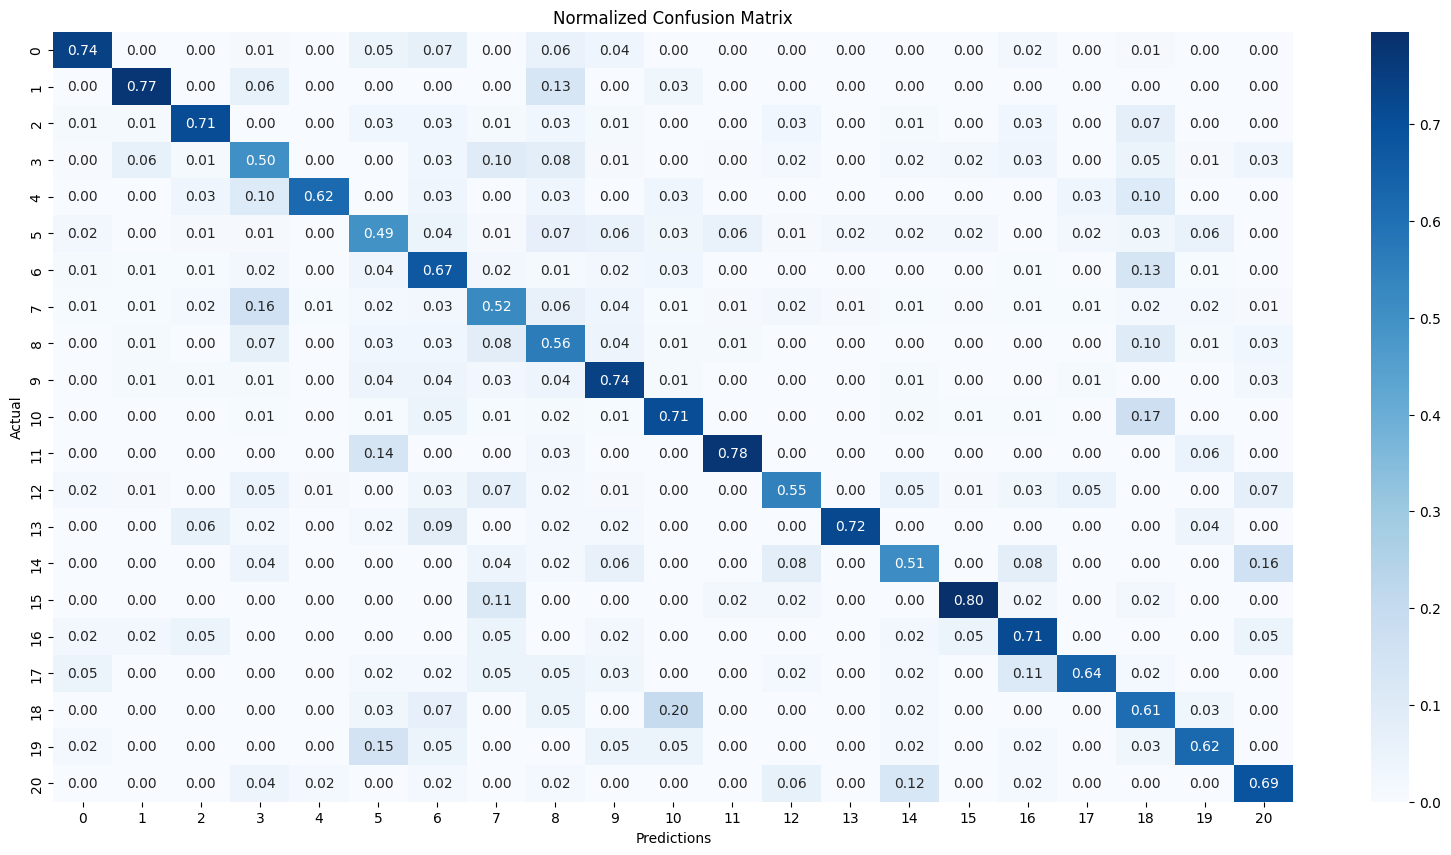

In [40]:
predicted_labels = np.argmax(prediction, axis=-1)

# Compute the confusion matrix (with normalization)
cf = confusion_matrix(y_test, predicted_labels, normalize='true')

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(cf, annot=True, cmap='Blues', fmt='.2f')  # fmt='.2f' for 2 decimal places
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Key Insights

### High Precision & Recall for Some Classes

* Class 11 (dyshidrotic-eczema) has a very high precision of 0.95 and recall of 0.83, indicating that it is well-predicted by the model.
* Class 6 (folliculitis) also has strong precision (0.87) and recall (0.88), making it one of the top-performing classes.

## Imbalance in Performance

* Class 18 (acne) has a relatively low F1-score (0.64), with precision of 0.58 and recall of 0.70, suggesting that the model struggles with accurately classifying acne compared to other classes.
* Class 4 (seborrheic-keratosis) has a relatively low precision (0.67) and recall (0.74), which might indicate some difficulty in distinguishing it from other similar conditions.

## Challenges in Classifying Certain Labels

* Class 9 (mycosis-fungoides) shows a high recall (0.93) but lower precision (0.69), which suggests that while the model is good at detecting it, it also makes a fair number of false positives.
* Class 17 (kaposi-sarcoma) has a high precision (0.90) but a lower recall (0.76), indicating that it’s accurate when predicted but is missed in some cases.

# Possible Areas for Improvement

## Handling Class Imbalance

* Classes like acne (18) and seborrheic-keratosis (4) show room for improvement. You may want to explore techniques like oversampling, undersampling, or class weights to better handle these imbalances.

## Model Fine-Tuning

Further fine-tuning the model, especially on classes with lower F1-scores, could help improve its performance. You might want to experiment with more complex models or data augmentation to boost performance on challenging classes.
Class-Specific Evaluation:

Since certain classes like acne and seborrheic-keratosis have lower scores, consider reviewing additional features or applying more specialized training techniques for these labels.

# Next Steps

Try model calibration or hyperparameter tuning to see if you can improve the performance on the classes with lower precision and recall.
Class balancing techniques like SMOTE or class weighting in the loss function could potentially help with the imbalance observed in the dataset.